# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [43]:
# Checking for GPU
!nvidia-smi

Sat Jan  8 19:11:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 497.29       Driver Version: 497.29       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   50C    P8    11W / 200W |   5774MiB /  6144MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Functions

In [3]:
# Plot the validation and training curves separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss'])) # how many epochs did we run for

  # Plot the loss
  plt.plot (epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  # Plot the accuracy
  plt.figure()
  plt.plot (epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()


# Creating a function for visualizing original, noised and denoised
def random_images(data1, data2, data3, title):
  """
  Visualizing random images form 3 separate datasets.
  Arguments:
        data1, data2, data3: numpy array
        title: list
  """

  n = 10
  indices = np.random.randint(len(data1), size=n)

  images1 = data1[indices, :]
  images2 = data2[indices, :]
  images3 = data3[indices, :]

  plt.figure(figsize=(24, 8))

  for i, (image1, image2, image3) in enumerate(zip(images1, images2, images3)):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(np.squeeze(image1), cmap='gray')
    plt.title(title[0])
    plt.axis(False);

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(np.squeeze(image2), cmap='gray')
    plt.title(title[1])
    plt.axis(False);

    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(np.squeeze(image3), cmap='gray')
    plt.title(title[2])
    plt.axis(False);

# Create a confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, title='Confusion Matrix'):
  """
  Confusion Matrix for Multiclass task.
  Arguments:
        y_true: True labels
        y_pred: Predicted labels
        classes: The names of classes
        figsize: Size of confusion matrix
        text_size: Size of text on confusion matrix
        title: Title of confusion matrix
  """


  # Create the confusion matrix 
  cm = confusion_matrix(y_true, tf.round(y_pred))
  cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize our confusion matrix
  n_classes = cm.shape[0]

  # Let's prettify it
  fig, ax = plt.subplots(figsize=figsize)
  # Create a matrix plot
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  # Set labels to be classes

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])


  # Label the axes
  ax.set(title = title,
        xlabel = 'Predicted Label',
        ylabel = 'True Label',
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels)

  # Set x-axis labels to bottom
  ax.xaxis.set_label_position('bottom')
  ax.xaxis.tick_bottom()

  #Adjust label size
  ax.yaxis.label.set_size(text_size)
  ax.xaxis.label.set_size(text_size)
  ax.title.set_size(25)

  # Set threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f'{cm[i, j]} ({cm_norm[i, j] * 100:.1f}%)',
            horizontalalignment='center',
            color='white' if cm[i, j] > threshold else 'black',
            size = text_size)


# Import Dataset

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 4s 0us/step


# Observe data

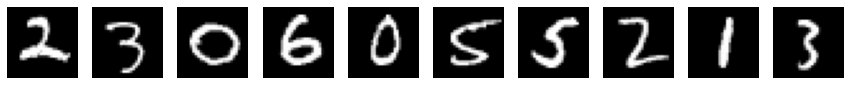

In [5]:
# Let's visualize random images
plt.figure(figsize=(15, 15))
indices = np.random.randint(len(x_train), size=10)
images1 = x_train[indices, :]
for i, image1 in enumerate(images1):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(image1, cmap='gray')
    plt.axis(False);

# Data preprocessing

In [6]:
# Rescale values of pixels
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape the dataset for CNN Autoencoder
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Task 2.1

## Adding noise

In [7]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

# Normalizing noisy images
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

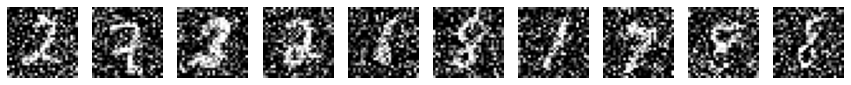

In [8]:
# Let's visualize random noised images
plt.figure(figsize=(15, 15))
indices = np.random.randint(len(x_train), size=10)
images1 = x_train_noisy[indices, :]
for i, image1 in enumerate(images1):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(np.squeeze(image1), cmap='gray')
    plt.axis(False);

## Autoencoder on ANN

In [9]:
# Changing shape for ANN Autoencoder
num_pixels = 28*28
x_train_ann = x_train.reshape(60000, num_pixels).astype('float32')
x_test_ann = x_test.reshape(10000, num_pixels).astype('float32')

### Creating the model

In [10]:
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
# Set the random value for reproducible result
tf.random.set_seed(42)

# Create the model
ann_autoencoder = Sequential([
  Flatten(input_shape=(28, 28)),
  Dense(512, activation ='relu'),
  Dense(256, activation ='relu'),
  Dense(32, activation ='relu'),
  Dense(256, activation ='relu'),
  Dense(512, activation ='relu'),
  Dense(784, activation ='sigmoid')
])

# Compile the model
ann_autoencoder.compile(loss = 'mean_squared_error',
                        optimizer = 'Adam',)

In [11]:
# Getting summary
ann_autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 32)                8224      
                                                                 
 dense_3 (Dense)             (None, 256)               8448      
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 dense_5 (Dense)             (None, 784)               4

### Fitting the model

In [12]:
# Set the random value for reproducible result
tf.random.set_seed(42)

# Fit the model
ann_history = ann_autoencoder.fit(x_train_noisy,
                    x_train_ann,
                    epochs = 10,
                    validation_data=(x_test_noisy, x_test_ann),
                    batch_size = 200)

Epoch 1/10
300/300 [==============================] - 12s 25ms/step - loss: 0.0524 - val_loss: 0.0328
Epoch 2/10
300/300 [==============================] - 3s 10ms/step - loss: 0.0290 - val_loss: 0.0258
Epoch 3/10
300/300 [==============================] - 3s 9ms/step - loss: 0.0246 - val_loss: 0.0231
Epoch 4/10
300/300 [==============================] - 3s 9ms/step - loss: 0.0223 - val_loss: 0.0214
Epoch 5/10
300/300 [==============================] - 3s 9ms/step - loss: 0.0208 - val_loss: 0.0207
Epoch 6/10
300/300 [==============================] - 3s 9ms/step - loss: 0.0198 - val_loss: 0.0194
Epoch 7/10
300/300 [==============================] - 3s 9ms/step - loss: 0.0189 - val_loss: 0.0192
Epoch 8/10
300/300 [==============================] - 3s 10ms/step - loss: 0.0182 - val_loss: 0.0187
Epoch 9/10
300/300 [==============================] - 3s 9ms/step - loss: 0.0176 - val_loss: 0.0184
Epoch 10/10
300/300 [==============================] - 3s 9ms/step - loss: 0.0171 - val_loss: 0.

<AxesSubplot:>

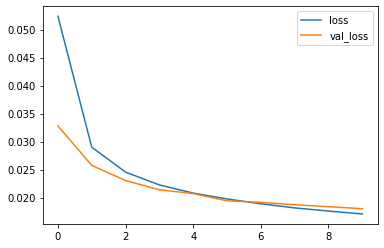

In [13]:
# Comparing validation and training loss 
pd.DataFrame(ann_history.history).plot()

### Predicting(Denoising images with Autoencoder(ANN))

In [14]:
ann_predicted = ann_autoencoder.predict(x_test_noisy)

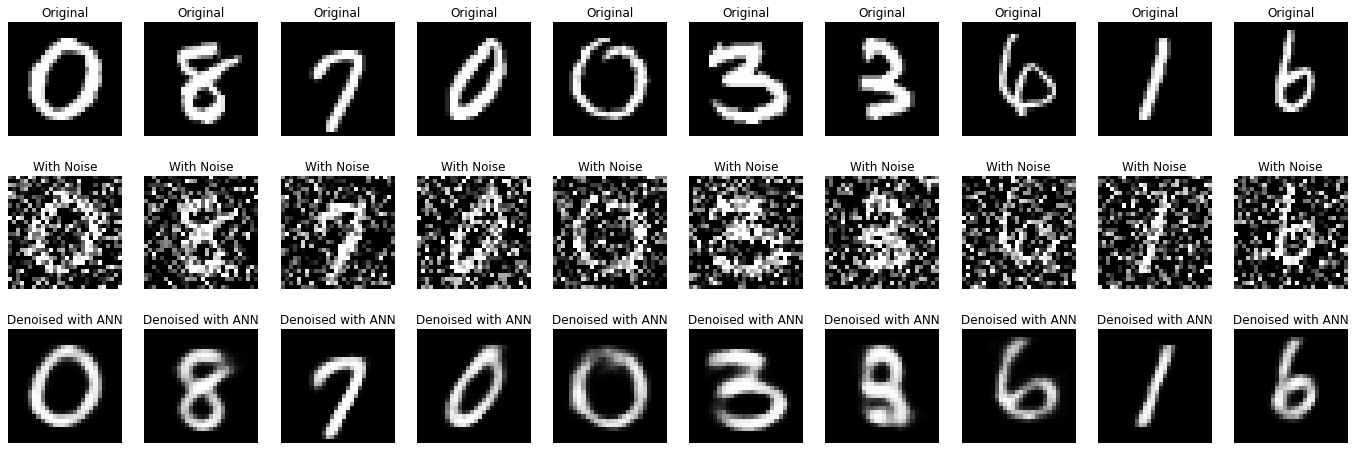

In [15]:
# Visualizing original, noised and denoised
random_images(x_test, x_test_noisy, np.reshape(ann_predicted, (len(ann_predicted), 28, 28)), title=['Original', 'With Noise', 'Denoised with ANN'])

## Autoencoder with CNN

### Creating the model

In [16]:
from tensorflow.keras.models import Model
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D

# Set the random value for reproducible result
tf.random.set_seed(42)

# Create the model

# Input layer
input = Input(shape=(28, 28, 1))

# Encoder
x = Conv2D(32, 3, activation='relu', padding="same")(input)
x = MaxPooling2D()(x)
x = Conv2D(16, 3, activation='relu', padding="same")(x)
x = MaxPooling2D()(x)

# Decoder
x = Conv2DTranspose(16, 3, strides=2, activation='relu', padding="same")(x)
x = Conv2DTranspose(32, 3, strides=2, activation='relu', padding="same")(x)
output = Conv2D(1, 3, activation="sigmoid", padding="same")(x)

cnn_autoencoder = Model(input, output)

# Compiling the model
cnn_autoencoder.compile(loss='binary_crossentropy', optimizer='Adam')

In [17]:
# Getting summary
cnn_autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 16)       2320  

### Fitting the model

In [18]:
# Set the random value for reproducible result
tf.random.set_seed(42)

# Fit the model
cnn_history = cnn_autoencoder.fit(x_train_noisy,
                    x_train,
                    epochs = 10,
                    validation_data=(x_test_noisy, x_test),
                    batch_size = 200)

Epoch 1/10
300/300 [==============================] - 18s 25ms/step - loss: 0.2442 - val_loss: 0.1325
Epoch 2/10
300/300 [==============================] - 6s 21ms/step - loss: 0.1267 - val_loss: 0.1208
Epoch 3/10
300/300 [==============================] - 6s 21ms/step - loss: 0.1190 - val_loss: 0.1156
Epoch 4/10
300/300 [==============================] - 6s 21ms/step - loss: 0.1152 - val_loss: 0.1128
Epoch 5/10
300/300 [==============================] - 6s 21ms/step - loss: 0.1128 - val_loss: 0.1111
Epoch 6/10
300/300 [==============================] - 6s 21ms/step - loss: 0.1112 - val_loss: 0.1096
Epoch 7/10
300/300 [==============================] - 6s 21ms/step - loss: 0.1100 - val_loss: 0.1084
Epoch 8/10
300/300 [==============================] - 6s 21ms/step - loss: 0.1089 - val_loss: 0.1080
Epoch 9/10
300/300 [==============================] - 6s 21ms/step - loss: 0.1082 - val_loss: 0.1069
Epoch 10/10
300/300 [==============================] - 6s 21ms/step - loss: 0.1075 - val_l

<AxesSubplot:>

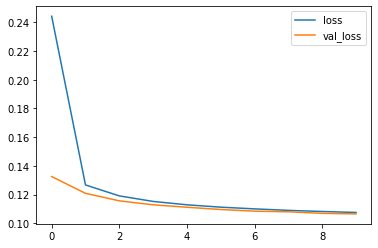

In [19]:
# Comparing validation and training loss 
pd.DataFrame(cnn_history.history).plot()

### Predicting(Denoising images with Autoencoder(CNN))

In [20]:
cnn_predicted = cnn_autoencoder.predict(x_test_noisy)

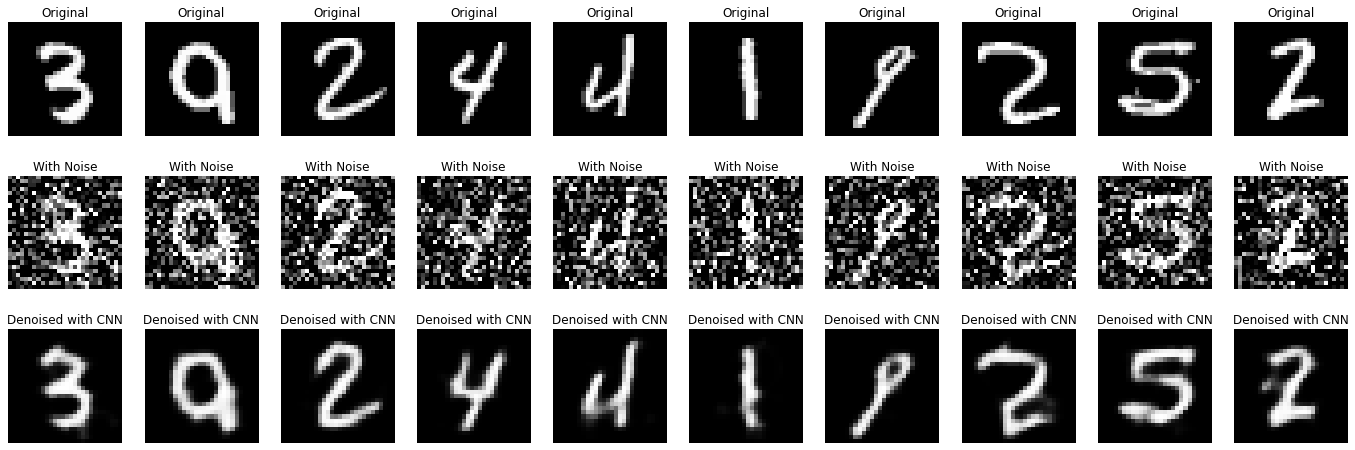

In [21]:
# Visualising original, noised and denoised(with CNN) images
random_images(x_test, x_test_noisy, np.array(cnn_predicted), title=['Original', 'With Noise', 'Denoised with CNN'])

## Comparing Autoencoders

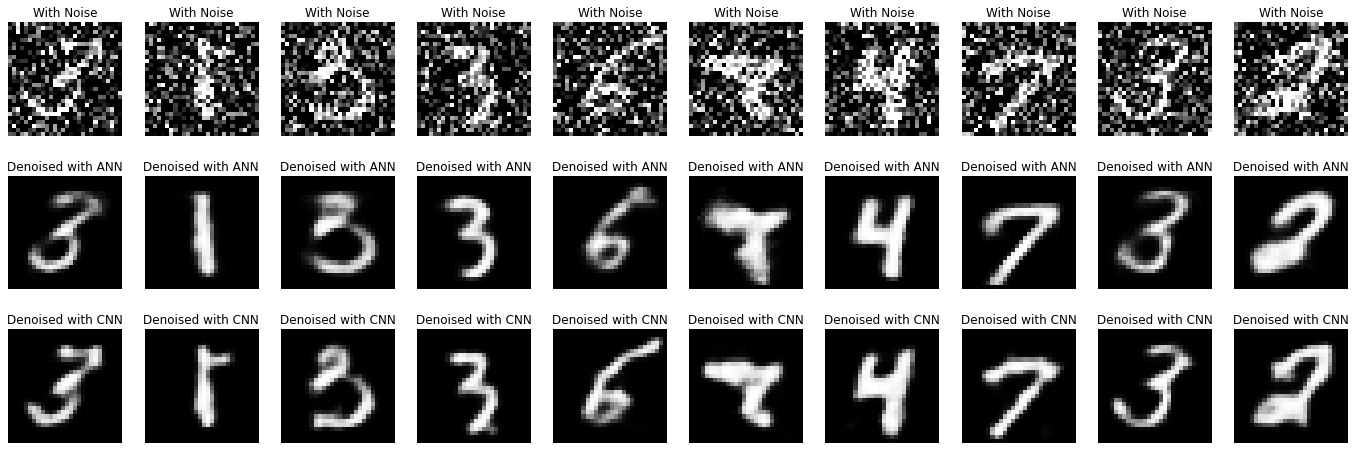

In [22]:
random_images(x_test_noisy, np.reshape(ann_predicted, (len(ann_predicted), 28, 28)), np.array(cnn_predicted),
              title=['With Noise','Denoised with ANN' , 'Denoised with CNN'])

# Task 2.2

### Creating Classifier

In [23]:
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense

# Set the random value for reproducible result
tf.random.set_seed(42)

# Creating the model
mnist_classifier = Sequential([
  Flatten(input_shape = (28, 28)),
  Dense(100, activation='relu'),
  Dense(100, activation='relu'),
  Dense(100, activation='relu'),
  Dense(10, activation='softmax'),
])

# Compiling the model
mnist_classifier.compile(loss = 'SparseCategoricalCrossentropy',
                        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                        metrics=['accuracy'])


### Fitting the model

In [24]:
# Set the random value for reproducible result
tf.random.set_seed(42)

# Fitting the model
classifier_history = mnist_classifier.fit(x_train,
                    y_train,
                    epochs = 5,
                    validation_data=(x_test, y_test),
                    batch_size = 200)

Epoch 1/5
300/300 [==============================] - 4s 9ms/step - loss: 0.3802 - accuracy: 0.8899 - val_loss: 0.1686 - val_accuracy: 0.9485
Epoch 2/5
300/300 [==============================] - 2s 7ms/step - loss: 0.1427 - accuracy: 0.9576 - val_loss: 0.1283 - val_accuracy: 0.9624
Epoch 3/5
300/300 [==============================] - 2s 7ms/step - loss: 0.1000 - accuracy: 0.9698 - val_loss: 0.1090 - val_accuracy: 0.9665
Epoch 4/5
300/300 [==============================] - 2s 7ms/step - loss: 0.0768 - accuracy: 0.9765 - val_loss: 0.0961 - val_accuracy: 0.9702
Epoch 5/5
300/300 [==============================] - 2s 7ms/step - loss: 0.0626 - accuracy: 0.9809 - val_loss: 0.0861 - val_accuracy: 0.9731


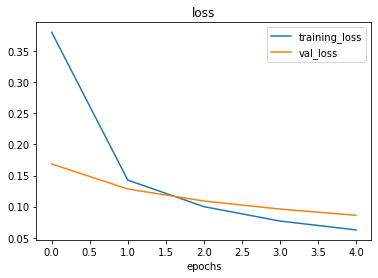

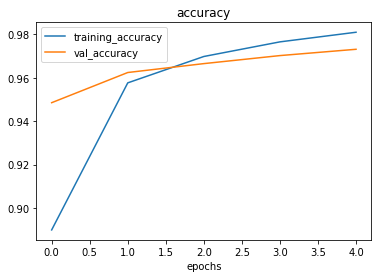

In [25]:
# Comparing validation and training loss (checking for overfitting)
plot_loss_curves(classifier_history)

In [26]:
# Evaluating the classifier
accuracy_classifier = mnist_classifier.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.0861 - accuracy: 0.9731


### Predictons on Normal Dataset

In [27]:
y_pred = mnist_classifier.predict(x_test)

# Taking max arguments and adding to list for confusion matrix
y_pred_classifier = []
for x in range(len(y_pred)):
  y_pred_classifier.append(tf.argmax(y_pred[x]))

### Visualizing metrics

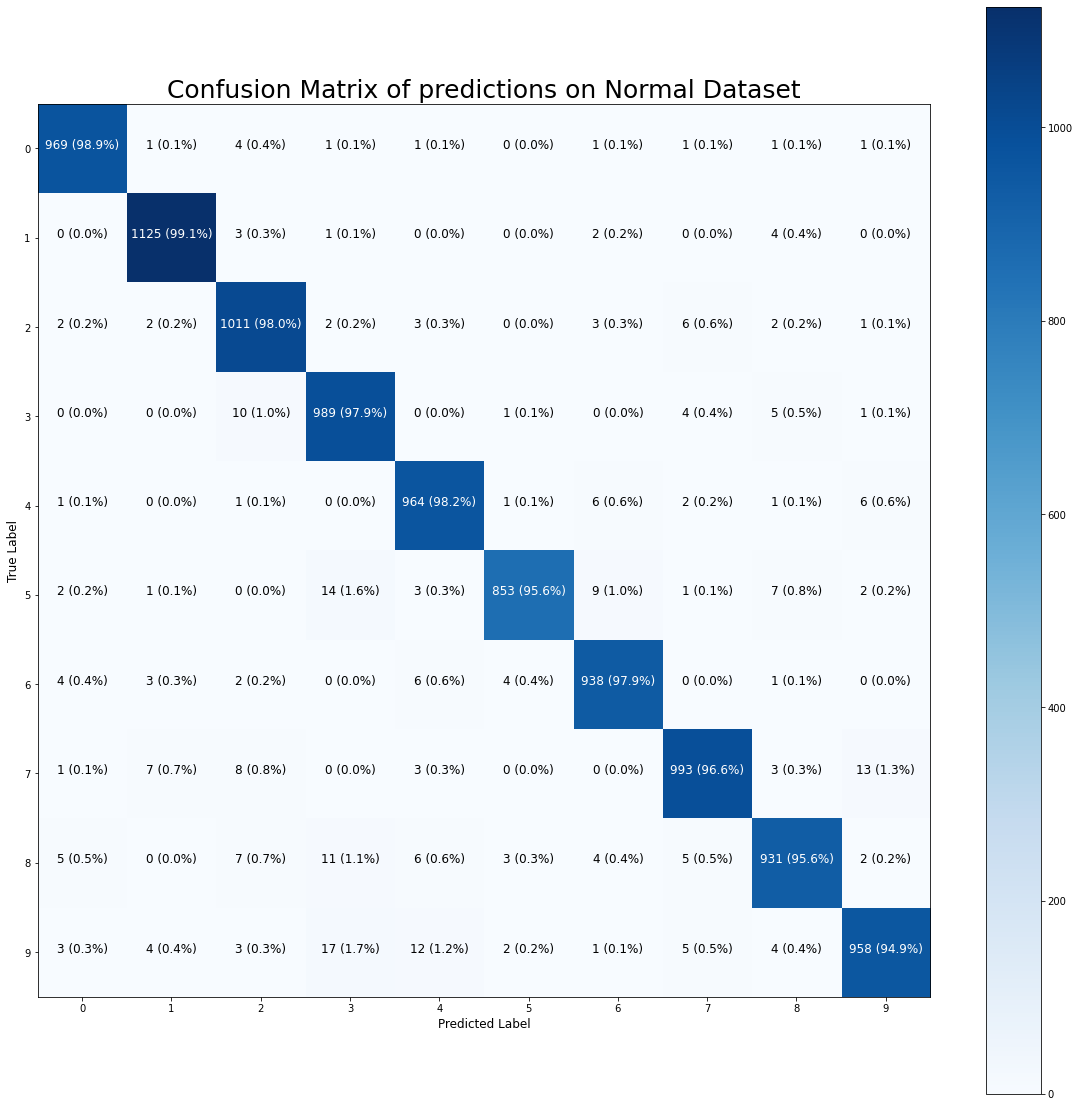

In [28]:
make_confusion_matrix(y_test, y_pred_classifier, classes=set(y_test), figsize=(20, 20), text_size=12, title='Confusion Matrix of predictions on Normal Dataset')

### Predictions on Noised Dataset

In [29]:
accuracy_noised = mnist_classifier.evaluate(x_test_noisy, y_test)   

313/313 [==============================] - 2s 5ms/step - loss: 4.2764 - accuracy: 0.2927


### Predictions on Denoised Datasets

#### Evaluating ANN Autoencoder

In [30]:
# Evaluating the autoencoder
accuracy_ann = mnist_classifier.evaluate(np.reshape(ann_predicted, (len(ann_predicted), 28, 28)), y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.2666 - accuracy: 0.9263


In [31]:
# Predicting
y_pred_ann = mnist_classifier.predict(np.reshape(ann_predicted, (len(ann_predicted), 28, 28)))

# Taking max arguments and adding to list for confusion matrix
y_predicted_ann = []
for x in range(len(y_pred_ann)):
  y_predicted_ann.append(tf.argmax(y_pred_ann[x]))

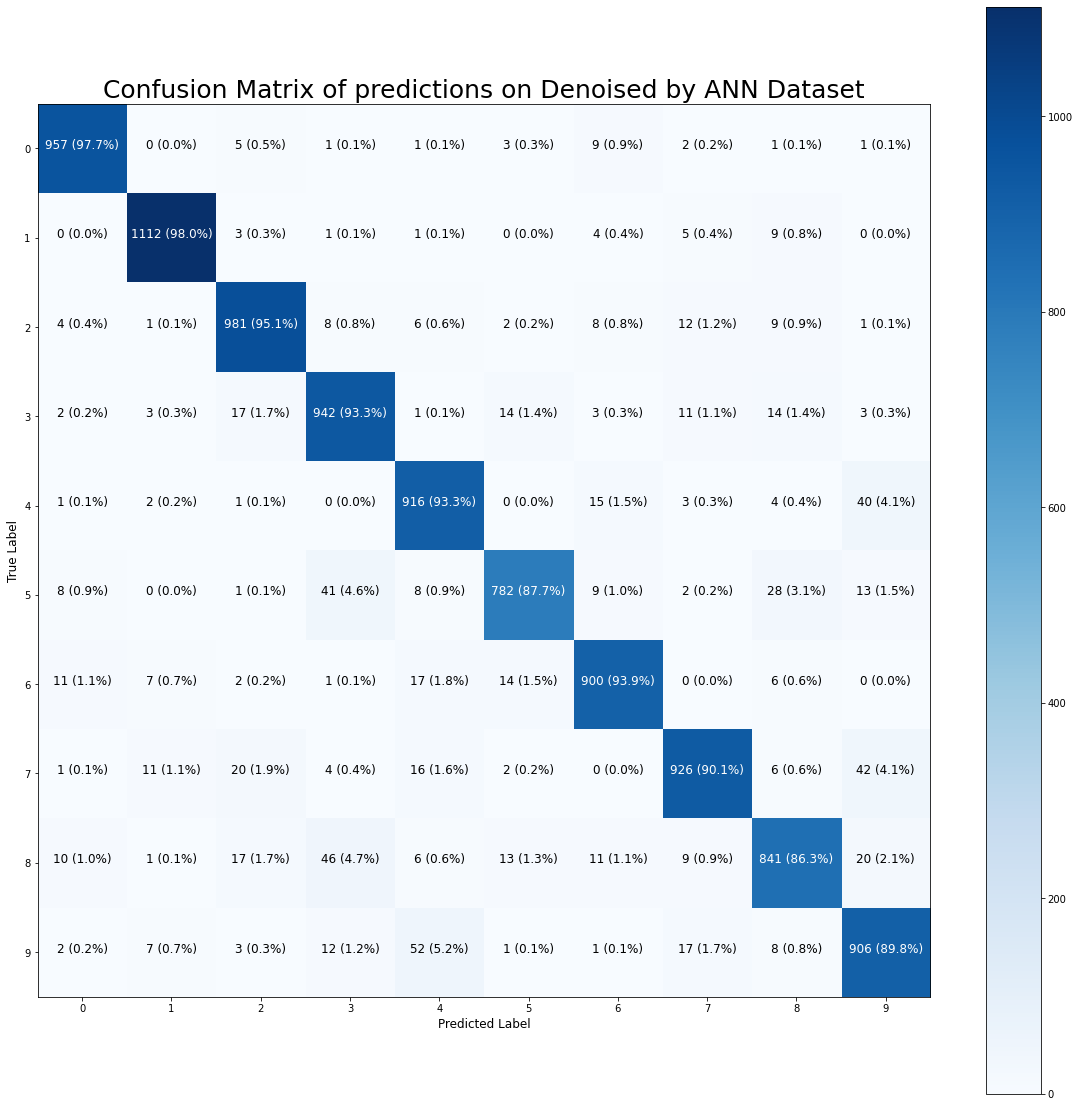

In [32]:
make_confusion_matrix(y_test, y_predicted_ann, classes=set(y_test),
                      figsize=(20, 20), text_size=12,
                      title='Confusion Matrix of predictions on Denoised by ANN Dataset')

In [33]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted_ann))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.97      0.98      0.98      1135
           2       0.93      0.95      0.94      1032
           3       0.89      0.93      0.91      1010
           4       0.89      0.93      0.91       982
           5       0.94      0.88      0.91       892
           6       0.94      0.94      0.94       958
           7       0.94      0.90      0.92      1028
           8       0.91      0.86      0.89       974
           9       0.88      0.90      0.89      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



#### Evaluating CNN Autoencoder

In [34]:
# Evaluating the autoencoder
accuracy_cnn = mnist_classifier.evaluate(np.array(cnn_predicted), y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.2128 - accuracy: 0.9368


In [35]:
# Predicting
y_pred_cnn = mnist_classifier.predict(np.array(cnn_predicted))

# Taking max arguments and adding to list for confusion matrix
y_predicted_cnn = []
for x in range(len(y_pred_cnn)):
  y_predicted_cnn.append(tf.argmax(y_pred_cnn[x]))

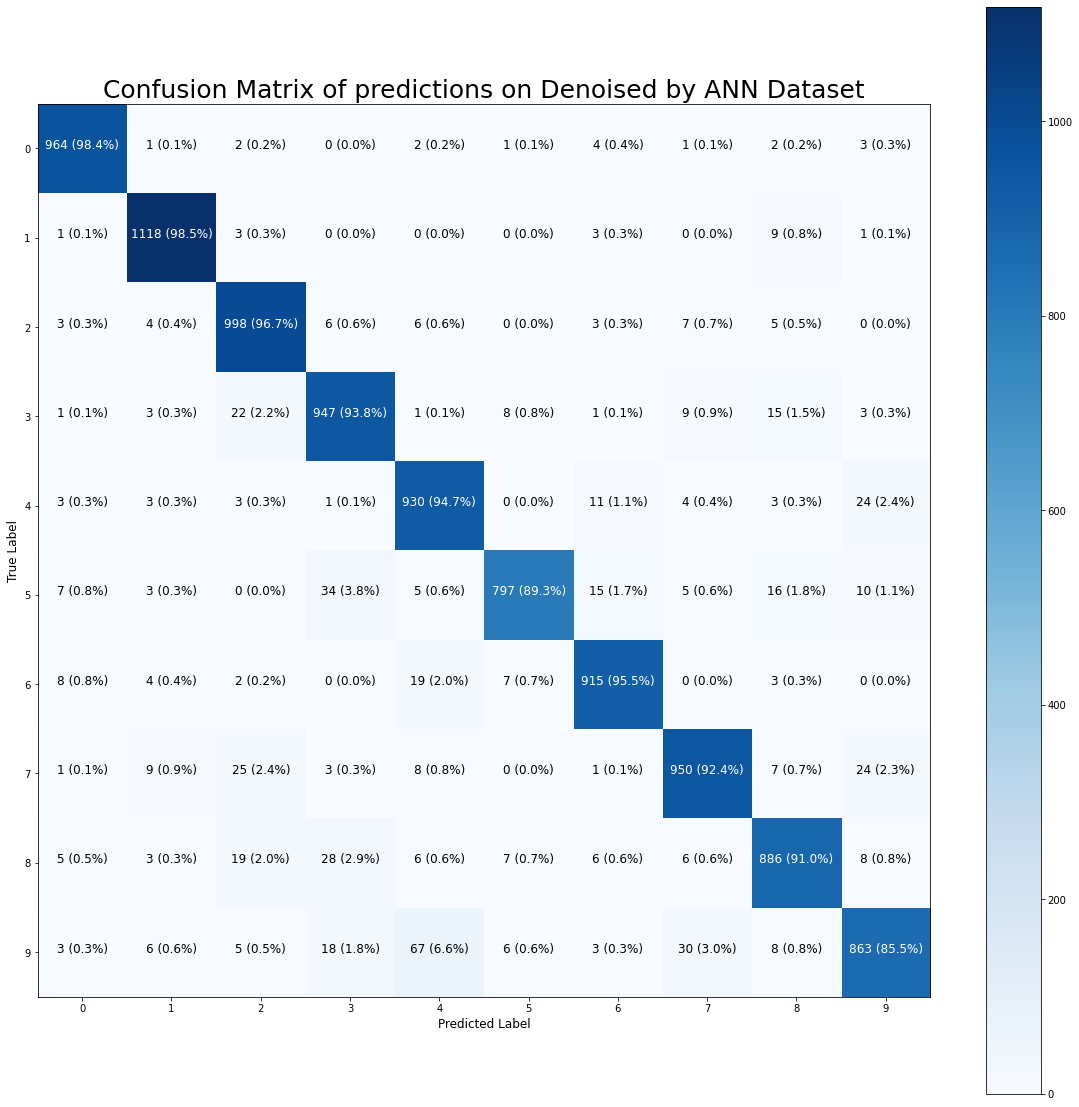

In [36]:
make_confusion_matrix(y_test, y_predicted_cnn, classes=set(y_test),
                      figsize=(20, 20), text_size=12,
                      title='Confusion Matrix of predictions on Denoised by ANN Dataset')

In [37]:
# Classificaiton report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted_cnn))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.97      0.99      0.98      1135
           2       0.92      0.97      0.95      1032
           3       0.91      0.94      0.93      1010
           4       0.89      0.95      0.92       982
           5       0.96      0.89      0.93       892
           6       0.95      0.96      0.95       958
           7       0.94      0.92      0.93      1028
           8       0.93      0.91      0.92       974
           9       0.92      0.86      0.89      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



### Visualizing Accuracy and Loss

In [38]:
# Creating pandas dataframe
dict1 = {'MNIST Dataset': accuracy_classifier, 'Dataset with Noise': accuracy_noised, 'ANN Denoised':accuracy_ann, 'CNN Denoised':accuracy_cnn}
accuracy_data = pd.DataFrame(dict1, index=['Loss', "Accuracy"])
accuracy_data.T

Loss  Accuracy
MNIST Dataset       0.086052    0.9731
Dataset with Noise  4.276379    0.2927
ANN Denoised        0.266613    0.9263
CNN Denoised        0.212789    0.9368

In [40]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

fig = make_subplots(column_widths= [0.1],rows=2, cols=1, subplot_titles=("Accuracy", "Loss"))

for i, name in enumerate(accuracy_data.columns):
  fig.add_trace(go.Bar(y=[accuracy_data.T['Accuracy'][i]], x = [name], name = 'Accuracy', width = 0.3, marker = dict(color = '#EB5160'),showlegend=False, legendgroup="group1"), row=1, col=1 )

for i, name in enumerate(accuracy_data.columns):
  fig.add_trace(go.Bar(y=[accuracy_data.T['Loss'][i]], x = [name], name = 'Loss', width = 0.3, marker = dict(color = '#476A6F'),showlegend=False, legendgroup="group2"), row=2, col=1 )

fig.update_layout(autosize=False,
      width=800,
      height=600,
      margin=dict(l=80, r=80, t=80, b=80),
      paper_bgcolor="#DFE0E2",
      legend=dict(
      orientation="h"),
      title= dict(text = "<b>Metrics</b>"))

# Saving models

In [41]:
# Save the ann autoencoder
ann_autoencoder.save('saved_trained_ann_autoencoder.h5')

In [42]:
# Save the cnn autoencoder
cnn_autoencoder.save('saved_trained_cnn_autoencoder.h5')